<a href="https://colab.research.google.com/github/data-sci-capstone/copilot/blob/alfonso/dialogSum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import regex as re
import matplotlib.pyplot as plt

from statistics import mean, median
from collections import defaultdict

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_df = pd.read_csv("./Datasets/flan_t5_large_labelled_train_no_topic.csv")
train_df.head()

,id,dialogue,summary,topic
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance


In [3]:
# total rows and columns
print(f"Total rows: {len(train_df)}\tTotal Columns: {len(train_df.columns)}")

Total rows: 12460	Total Columns: 4


In [4]:
range_of_topics = set(train_df["topic"])
print(f"Range of topics in dialogSum: {len(range_of_topics)}")

Range of topics in dialogSum: 7434


In [5]:
#checking for dup id's
print(f"There are a total of {len(set(train_df['id']))} unique rows.")

There are a total of 12460 unique rows.


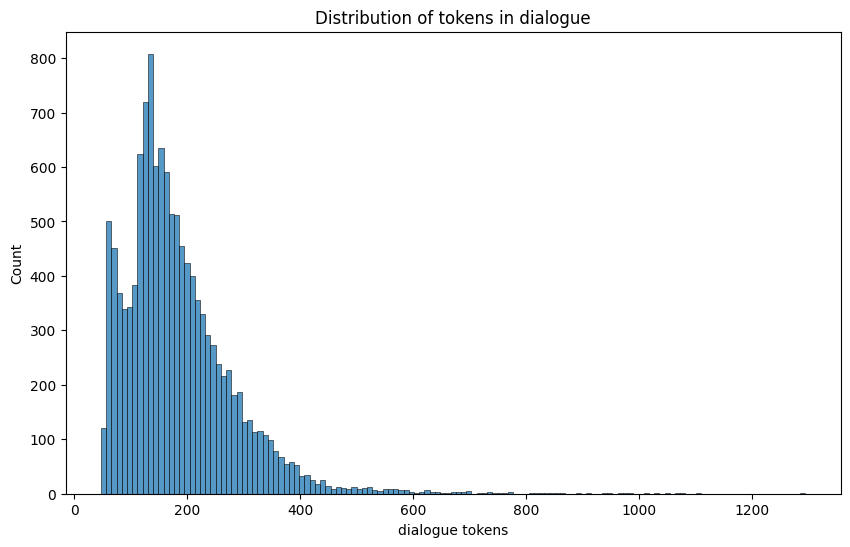

In [6]:
plt.figure(figsize = (10, 6))
sns.histplot(data=train_df["dialogue"].str.len() / 4)
plt.title("Distribution of tokens in dialogue")
plt.xlabel("dialogue tokens")
plt.show()

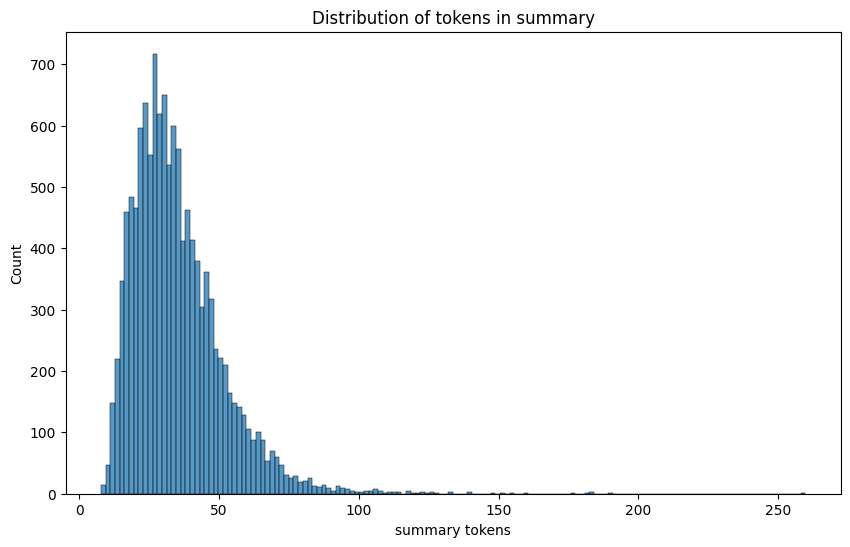

In [7]:
plt.figure(figsize = (10, 6))
sns.histplot(data=train_df["summary"].str.len() / 4)
plt.title("Distribution of tokens in summary")
plt.xlabel("summary tokens")
plt.show()

In [8]:
topics = defaultdict(int)
for topic in train_df["topic"]:
  topics[topic] += 1

topics = sorted(topics.items(), key= lambda x: x[1], reverse = True)
topics[:10]

[('shopping', 174),
 ('job interview', 161),
 ('daily casual talk', 125),
 ('phone call', 89),
 ('order food', 79),
 ('interview', 77),
 ('social meeting', 56),
 ('business talk', 48),
 ('see a doctor', 46),
 ('weather', 42)]

In [9]:
train_df["dialogue_tokens"] = train_df["dialogue"].apply(lambda x: len(x) / 4)
train_df.head()

,id,dialogue,summary,topic,dialogue_tokens
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up,232.75
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines,194.00
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys,125.00
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend,131.50
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance,120.00


In [10]:
train_df["summary_tokens"] = train_df["summary"].apply(lambda x: len(x) / 4)
train_df.head()

,id,dialogue,summary,topic,dialogue_tokens,summary_tokens
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up,232.75,46.75
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines,194.00,25.25
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys,125.00,20.25
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend,131.50,27.50
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance,120.00,23.25


In [ ]:
train_df["summary"]

# Mutate train_df to include sentiment. For now, randomly generated values of 0,1, 2 are provided.

In [11]:
train_df["sentiment"] = np.random.randint(0, 3, size = 12460)
train_df.head()

,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up,232.75,46.75,1
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines,194.00,25.25,1
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys,125.00,20.25,1
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend,131.50,27.50,0
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance,120.00,23.25,0


# Check for duplicate values: Dialogue

In [12]:
"""
process_text simply strips away non alphanumeric characters including spaces
:param: string
:return: string
"""
def process_text(text: str)->str:
    processed_text = text.lower()
    processed_text = re.sub(r'[^a-zA-Z0-9\s]','', text)
    processed_text = re.sub(r'\s+', ' ', text)
    processed_text = processed_text.strip()
    return processed_text

In [13]:
len(set(train_df["dialogue"]))

12458

In [29]:
# Find duplicate dialogues and check for whether the row is the same as a whole.
dialogues = defaultdict(int)

for dialogue in train_df["dialogue"]:
  processed_dialogue = process_text(dialogue)
  dialogues[processed_dialogue] += 1

duplicate_dialogue = set()
total_duplicate_dialogues = 0
for dialogue, count in dialogues.items():
  if count > 1:
    total_duplicate_dialogues += count - 1
    duplicate_dialogue.add(dialogue)

print(f"Number of duplicate dialogues: {total_duplicate_dialogues}")

Number of duplicate dialogues: 597


In [ ]:
for dial in train_df["dialogue"]:
  if process_text(dial) in duplicate_dialogue:
    display(train_df[train_df["dialogue"] == dial])

In [16]:
train_df[train_df["id"] == "train_1626"]

,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1626,train_1626,#Person1#: Any plans tonight? \n#Person2#: Not...,#Person1# invites #Person2# to have a drink be...,social communication,215.0,45.0,0


In [17]:
train_df[train_df["id"] == "train_9118"]

,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
9118,train_9118,#Person1#: Any plans tonight? \n#Person2#: Not...,#Person1# invites #Person2# to take a hang-out...,after inteview,215.0,49.75,1


# Check for duplicates: Summaries

In [18]:
len(set(train_df["summary"]))

12436

In [31]:
# Find duplicate dialogues and check for whether the row is the same as a whole.
summaries = defaultdict(int)
for summary in train_df["summary"]:
  processed_summary = process_text(summary)
  summaries[processed_summary] += 1

duplicate_summary = set()
total_duplicate_summaries = 0
for summary, count in summaries.items():
  if count > 1:
    total_duplicate_summaries += count - 1
    duplicate_summary.add(summary)

print(f"Number of duplicate summaries: {total_duplicate_summaries}")

Number of duplicate summaries: 24


In [20]:
for summ in train_df["summary"]:
  if process_text(summ) in duplicate_summary:
    display(train_df[train_df["summary"] == summ])

,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
250,train_250,#Person1#: There is a tornado warning on. My m...,#Person1# explains to #Person2# the details ab...,a tornado warning,519.50,92.75,1
7862,train_7862,#Person1#: There is a tornado warning on. My m...,#Person1# explains to #Person2# the details ab...,discuss tornadoes,525.25,92.75,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
254,train_254,"#Person1#: Tom, aren't you a little too old to...",#Person1# thinks Tom is too old to be trick-or...,trick-or-treating,132.25,21.0,2
5762,train_5762,"#Person1#: Tom, aren't you a little too old to...",#Person1# thinks Tom is too old to be trick-or...,trick-or-treat,132.75,21.0,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1085,train_1085,#Person1#: I'd like to take this opportunity t...,#Person1# thanks #Person2# for #Person2#'s help.,gratitude,61.0,12.0,0
9605,train_9605,#Person1#: I'd like to take this opportunity t...,#Person1# thanks #Person2# for #Person2#'s help.,thanks,62.0,12.0,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1178,train_1178,#Person1#: Are you going to watch the Indy Fiv...,#Person1# is surprised at Taylor whose hobbies...,change,134.75,21.0,1
5841,train_5841,#Person1#: Are you going to watch the Indy Fiv...,#Person1# is surprised at Taylor whose hobbies...,changes,131.50,21.0,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1237,train_1237,#Person1#: I met a girl in elevator this morni...,#Person1# complains about the strict dressing ...,dress for work,214.25,50.25,1
5146,train_5146,#Person1#: I met a girl in elevator this morni...,#Person1# complains about the strict dressing ...,dressing rule,236.75,50.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1550,train_1550,#Person1#: Hello there! Come on in! Don't just...,#Person2# wants a trim. #Person1# serves #Pers...,hairstyle,172.00,33.0,1
1976,train_1976,#Person1#: Hello there! Come on in! Don't just...,#Person2# wants a trim. #Person1# serves #Pers...,haircut,176.75,33.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1578,train_1578,#Person1#: Tomorrow will be my first day at wo...,#Person2# offers #Person1# some suggestions on...,work wearing,178.50,23.25,2
3702,train_3702,"#Person1#: Tomorrow is my first day at work, w...",#Person2# offers #Person1# some suggestions on...,dressing suggestions,176.75,23.25,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1550,train_1550,#Person1#: Hello there! Come on in! Don't just...,#Person2# wants a trim. #Person1# serves #Pers...,hairstyle,172.00,33.0,1
1976,train_1976,#Person1#: Hello there! Come on in! Don't just...,#Person2# wants a trim. #Person1# serves #Pers...,haircut,176.75,33.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
2026,train_2026,#Person1#: what a nice garden! Look at these t...,#Person1# takes several pictures for #Person2#...,take pictures,194.75,43.25,1
8249,train_8249,#Person1#: what a nice garden! Look at these t...,#Person1# takes several pictures for #Person2#...,take pictures,197.25,43.25,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
2496,train_2496,#Person1#: I'm going to go shopping for grocer...,#Person1#'s going shopping for groceries but d...,shopping for groceries,130.75,27.25,0
6135,train_6135,#Person1#: I'm going to go shopping for grocer...,#Person1#'s going shopping for groceries but d...,go shopping,133.75,27.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
2680,train_2680,"#Person1#: Tom, you promised to cut the lung. ...",#Person1# lists several things to ask Tom for ...,promise,153.25,14.75,2
10360,train_10360,"#Person1#: Tom, you promised to cut the lung. ...",#Person1# lists several things to ask Tom for ...,keep promises,150.25,14.75,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
2693,train_2693,"#Person1#: Can I help you?\n#Person2#: Yes, I'...",#Person2# wants to rent a big house and #Perso...,house renting,196.00,33.75,1
2705,train_2705,"#Person1#: Can I help you?\n#Person2#: Yes, I'...",#Person2# wants to rent a big house and #Perso...,house renting,195.75,33.75,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
2693,train_2693,"#Person1#: Can I help you?\n#Person2#: Yes, I'...",#Person2# wants to rent a big house and #Perso...,house renting,196.00,33.75,1
2705,train_2705,"#Person1#: Can I help you?\n#Person2#: Yes, I'...",#Person2# wants to rent a big house and #Perso...,house renting,195.75,33.75,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
3394,train_3394,#Person1#: How do you feel?\n#Person2#: I like...,#Person2# tries on clothes and then bargains w...,shopping,55.5,15.0,0
3403,train_3403,#Person1#: How do you feel? \n#Person2#: I lik...,#Person2# tries on clothes and then bargains w...,shopping,56.5,15.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
3394,train_3394,#Person1#: How do you feel?\n#Person2#: I like...,#Person2# tries on clothes and then bargains w...,shopping,55.5,15.0,0
3403,train_3403,#Person1#: How do you feel? \n#Person2#: I lik...,#Person2# tries on clothes and then bargains w...,shopping,56.5,15.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1578,train_1578,#Person1#: Tomorrow will be my first day at wo...,#Person2# offers #Person1# some suggestions on...,work wearing,178.50,23.25,2
3702,train_3702,"#Person1#: Tomorrow is my first day at work, w...",#Person2# offers #Person1# some suggestions on...,dressing suggestions,176.75,23.25,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
4327,train_4327,#Person1#: Would you like to have dinner with ...,#Person1# invites #Person2# to dinner. #Person...,dinner invitation,63.5,14.0,1
8024,train_8024,#Person1#: Are you free tomorrow night?\n#Pers...,#Person1# invites #Person2# to dinner. #Person...,dinner invitation,65.0,14.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
4619,train_4619,"#Person1#: Billy, you are late again.\n#Person...",Bill's late again because of oversleeping. #Pe...,at the office,173.75,32.0,1
7684,train_7684,"#Person1#: Billy, you are late again.\n#Person...",Bill's late again because of oversleeping. #Pe...,late for work,165.00,32.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
4909,train_4909,#Person1#: May I take your order?\n#Person2#: ...,#Person1# gives #Person2# the menu and recomme...,food ordering,66.25,17.5,0
9115,train_9115,#Person1#: May I take your order? \n#Person2#:...,#Person1# gives #Person2# the menu and recomme...,Taking order,67.50,17.5,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
5058,train_5058,#Person1#: Excuse me. Could you tell me where ...,#Person2# shows #Person1# the way to the post ...,ask the way,66.25,13.25,2
10168,train_10168,"#Person1#: Excuse me, can you tell me where th...",#Person2# shows #Person1# the way to the post ...,showing the way,62.00,13.25,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1237,train_1237,#Person1#: I met a girl in elevator this morni...,#Person1# complains about the strict dressing ...,dress for work,214.25,50.25,1
5146,train_5146,#Person1#: I met a girl in elevator this morni...,#Person1# complains about the strict dressing ...,dressing rule,236.75,50.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
5760,train_5760,"#Person1#: Hello, is this the ABC company?\n#P...",#Person1# reserved a car from ABC company but ...,phone call,126.5,27.25,2
5780,train_5780,"#Person1#: Hello, is this the ABC Company?\n#P...",#Person1# reserved a car from ABC company but ...,phone call,129.0,27.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
254,train_254,"#Person1#: Tom, aren't you a little too old to...",#Person1# thinks Tom is too old to be trick-or...,trick-or-treating,132.25,21.0,2
5762,train_5762,"#Person1#: Tom, aren't you a little too old to...",#Person1# thinks Tom is too old to be trick-or...,trick-or-treat,132.75,21.0,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
5760,train_5760,"#Person1#: Hello, is this the ABC company?\n#P...",#Person1# reserved a car from ABC company but ...,phone call,126.5,27.25,2
5780,train_5780,"#Person1#: Hello, is this the ABC Company?\n#P...",#Person1# reserved a car from ABC company but ...,phone call,129.0,27.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1178,train_1178,#Person1#: Are you going to watch the Indy Fiv...,#Person1# is surprised at Taylor whose hobbies...,change,134.75,21.0,1
5841,train_5841,#Person1#: Are you going to watch the Indy Fiv...,#Person1# is surprised at Taylor whose hobbies...,changes,131.50,21.0,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
2496,train_2496,#Person1#: I'm going to go shopping for grocer...,#Person1#'s going shopping for groceries but d...,shopping for groceries,130.75,27.25,0
6135,train_6135,#Person1#: I'm going to go shopping for grocer...,#Person1#'s going shopping for groceries but d...,go shopping,133.75,27.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
6189,train_6189,#Person1#: How much does it cost for a bus pas...,#Person1# asks #Person2# some questions about ...,bus pass,135.25,28.5,1
6640,train_6640,#Person1#: How much for a bus pass?\n#Person2#...,#Person1# asks #Person2# some questions about ...,bus pass,145.75,28.5,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
6312,train_6312,#Person1#: I would like to get some meat today...,#Person1# buys a pound of ground beef and thre...,shop for meat,139.50,22.25,1
8989,train_8989,#Person1#: I would like to purchase some meat....,#Person1# buys a pound of ground beef and thre...,buy meat,136.75,22.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
6189,train_6189,#Person1#: How much does it cost for a bus pas...,#Person1# asks #Person2# some questions about ...,bus pass,135.25,28.5,1
6640,train_6640,#Person1#: How much for a bus pass?\n#Person2#...,#Person1# asks #Person2# some questions about ...,bus pass,145.75,28.5,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
4619,train_4619,"#Person1#: Billy, you are late again.\n#Person...",Bill's late again because of oversleeping. #Pe...,at the office,173.75,32.0,1
7684,train_7684,"#Person1#: Billy, you are late again.\n#Person...",Bill's late again because of oversleeping. #Pe...,late for work,165.00,32.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
250,train_250,#Person1#: There is a tornado warning on. My m...,#Person1# explains to #Person2# the details ab...,a tornado warning,519.50,92.75,1
7862,train_7862,#Person1#: There is a tornado warning on. My m...,#Person1# explains to #Person2# the details ab...,discuss tornadoes,525.25,92.75,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
4327,train_4327,#Person1#: Would you like to have dinner with ...,#Person1# invites #Person2# to dinner. #Person...,dinner invitation,63.5,14.0,1
8024,train_8024,#Person1#: Are you free tomorrow night?\n#Pers...,#Person1# invites #Person2# to dinner. #Person...,dinner invitation,65.0,14.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
2026,train_2026,#Person1#: what a nice garden! Look at these t...,#Person1# takes several pictures for #Person2#...,take pictures,194.75,43.25,1
8249,train_8249,#Person1#: what a nice garden! Look at these t...,#Person1# takes several pictures for #Person2#...,take pictures,197.25,43.25,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
8822,train_8822,"#Person1#: Excuse me, sir, didn't you see the ...",#Person1# gives #Person2# a ticket because he ...,give a ticket,133.25,29.25,0
11236,train_11236,"#Person1#: Excuse me, sir. Didn't you see the ...",#Person1# gives #Person2# a ticket because he ...,give a ticket,132.75,29.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
8975,train_8975,#Person1#: I'm not a Christian. I just want to...,#Person1#'s not Christian and wants to know wh...,religion discussion,233.75,30.75,2
11611,train_11611,#Person1#: I'm not a Christian. I just want to...,#Person1#'s not Christian and wants to know wh...,religion,232.00,30.75,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
6312,train_6312,#Person1#: I would like to get some meat today...,#Person1# buys a pound of ground beef and thre...,shop for meat,139.50,22.25,1
8989,train_8989,#Person1#: I would like to purchase some meat....,#Person1# buys a pound of ground beef and thre...,buy meat,136.75,22.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
4909,train_4909,#Person1#: May I take your order?\n#Person2#: ...,#Person1# gives #Person2# the menu and recomme...,food ordering,66.25,17.5,0
9115,train_9115,#Person1#: May I take your order? \n#Person2#:...,#Person1# gives #Person2# the menu and recomme...,Taking order,67.50,17.5,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
9508,train_9508,"#Person1#: What's the matter with you, then? Y...",#Person2# thinks #Person1# and #Person2# used ...,marriage,136.25,42.0,2
11313,train_11313,"#Person1#: What's the matter with you, then? Y...",#Person2# thinks #Person1# and #Person2# used ...,relationship predicament,135.75,42.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
1085,train_1085,#Person1#: I'd like to take this opportunity t...,#Person1# thanks #Person2# for #Person2#'s help.,gratitude,61.0,12.0,0
9605,train_9605,#Person1#: I'd like to take this opportunity t...,#Person1# thanks #Person2# for #Person2#'s help.,thanks,62.0,12.0,1


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
9835,train_9835,"#Person1#: Good morning, Madam, can I take you...",#Person1# helps #Person2# order a roast chicke...,order,197.0,34.0,1
9850,train_9850,"#Person1#: Good morning, Madam, can I take you...",#Person1# helps #Person2# order a roast chicke...,order,202.5,34.0,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
9835,train_9835,"#Person1#: Good morning, Madam, can I take you...",#Person1# helps #Person2# order a roast chicke...,order,197.0,34.0,1
9850,train_9850,"#Person1#: Good morning, Madam, can I take you...",#Person1# helps #Person2# order a roast chicke...,order,202.5,34.0,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
5058,train_5058,#Person1#: Excuse me. Could you tell me where ...,#Person2# shows #Person1# the way to the post ...,ask the way,66.25,13.25,2
10168,train_10168,"#Person1#: Excuse me, can you tell me where th...",#Person2# shows #Person1# the way to the post ...,showing the way,62.00,13.25,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
2680,train_2680,"#Person1#: Tom, you promised to cut the lung. ...",#Person1# lists several things to ask Tom for ...,promise,153.25,14.75,2
10360,train_10360,"#Person1#: Tom, you promised to cut the lung. ...",#Person1# lists several things to ask Tom for ...,keep promises,150.25,14.75,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
10525,train_10525,#Person1#: I need to find the cereal aisle. \n...,#Person2# tells #Person1# where to find the ce...,offer information,133.75,21.75,1
11253,train_11253,#Person1#: I can't seem to find the cereal ais...,#Person2# tells #Person1# where to find the ce...,ask for help,152.00,21.75,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
8822,train_8822,"#Person1#: Excuse me, sir, didn't you see the ...",#Person1# gives #Person2# a ticket because he ...,give a ticket,133.25,29.25,0
11236,train_11236,"#Person1#: Excuse me, sir. Didn't you see the ...",#Person1# gives #Person2# a ticket because he ...,give a ticket,132.75,29.25,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
10525,train_10525,#Person1#: I need to find the cereal aisle. \n...,#Person2# tells #Person1# where to find the ce...,offer information,133.75,21.75,1
11253,train_11253,#Person1#: I can't seem to find the cereal ais...,#Person2# tells #Person1# where to find the ce...,ask for help,152.00,21.75,2


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
9508,train_9508,"#Person1#: What's the matter with you, then? Y...",#Person2# thinks #Person1# and #Person2# used ...,marriage,136.25,42.0,2
11313,train_11313,"#Person1#: What's the matter with you, then? Y...",#Person2# thinks #Person1# and #Person2# used ...,relationship predicament,135.75,42.0,0


,id,dialogue,summary,topic,dialogue_tokens,summary_tokens,sentiment
8975,train_8975,#Person1#: I'm not a Christian. I just want to...,#Person1#'s not Christian and wants to know wh...,religion discussion,233.75,30.75,2
11611,train_11611,#Person1#: I'm not a Christian. I just want to...,#Person1#'s not Christian and wants to know wh...,religion,232.00,30.75,0


In [21]:
train_df.iloc[1085, 1]

"#Person1#: I'd like to take this opportunity to thank you for everything you did for me.\n#Person2#: It's my pleasure. I enjoyed working with you.\n#Person1#: I wouldn't be able to make it without your help.\n#Person2#: Then keep up the good work."

In [22]:
train_df.iloc[9605, 1]

"#Person1#: I'd like to take this opportunity to thank you for everything you did for me. \n#Person2#: It's my pleasure. I enjoyed working with you. \n#Person1#: I wouldn't be able to make it without your help. \n#Person2#: Then keep up the good work. "

In [23]:
train_df.iloc[254, 1]

"#Person1#: Tom, aren't you a little too old to be trick-or-treating?\n#Person2#: What are you talking about? Where is your Halloween spirit? Didn't you ever dress up in a costume and go around the neighborhood trick-or-treating with your friends?\n#Person1#: Of course, I did, but when I was ten! Trick - or-treating is for kids, plus, I'm sure people will think you're a kidnapper or something, running around with kids NCP at night.\n#Person2#: Whatever, I'm going next door I heard Mrs. Robinson is giving out big bags of M & Ms!"

In [24]:
train_df.iloc[5762, 1]

"#Person1#: Tom, aren't you a little too old to be trick-or - treating?\n#Person2#: What are you talking about? Where is your Halloween spirit? Didn't you ever dress up in a costume and go around the neighborhood trick-or-treating with your friends?\n#Person1#: Of course, I did, but when I was ten! Trick - or-treating is for kids, plus, I'm sure people will think you're a kidnapper or something, running around with kids NCP at night.\n#Person2#: Whatever, I'm going next door I heard Mrs. Robinson is giving out big bags of M & Ms!"

In [25]:
data = []
train_df["dialogue"].apply(lambda x: data.append(len(x.split(" "))))
average_text_len = mean(data)
median_text_len = median(data)
total_words = sum(data)
average_adult_wpm = 236 # https://wordsrated.com/reading-speed-statistics/
text_in_hours = math.ceil(((total_words / average_adult_wpm) / 60))
group_size = 4

print(f"Average text length by words: {math.ceil(average_text_len)}.\nMedian Text length by words: {math.ceil(median_text_len)}.\nTotal amount of text by words: {math.ceil(total_words)}\n\
Estimated time to read all text in hours: {text_in_hours}\nEstimated time per person in a group of 4: {math.ceil(text_in_hours / group_size)}")

Average text length by words: 124.
Median Text length by words: 109.
Total amount of text by words: 1541488
Estimated time to read all text in hours: 109
Estimated time per person in a group of 4: 28
